In [20]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
import gc

# IN-situ Data

In [5]:
insitu = "/kaggle/input/windspeed-comparison-italy-2009/insitu_windspeed_2009.csv"
df_insitu = pd.read_csv(insitu)
df_insitu.head(12)

,Unnamed: 0,actual_time,latitude,longitude,air_pressure,observed_value
0,0,2009-01-01 00:00:00+00:00,37.9142,12.4914,100000.0,8.700
1,1,2009-01-01 00:00:00+00:00,40.6603,17.9567,100000.0,3.350
2,2,2009-01-01 00:00:00+00:00,41.6700,12.4508,100000.0,9.750
3,3,2009-01-01 00:00:00+00:00,41.9181,8.7928,100000.0,4.110
4,4,2009-01-01 00:00:00+00:00,44.0969,15.3403,100000.0,5.515
5,5,2009-01-01 00:00:00+00:00,44.5392,7.6125,98000.0,1.000
6,6,2009-01-01 00:00:00+00:00,44.6539,11.6225,100000.0,4.440
7,7,2009-01-01 00:00:00+00:00,45.4614,9.2831,100000.0,1.500
8,8,2009-01-01 00:00:00+00:00,46.0375,13.1883,100000.0,2.850
9,9,2009-01-01 00:00:00+00:00,46.8117,6.9425,96600.0,1.000


# CERRA Data

In [3]:
cerra = "/kaggle/input/windspeed-comparison-italy-2009/cerra_italy_windspeed_2009_csv.csv"
df_cerra = pd.read_csv(cerra)
df_cerra.head()

,Unnamed: 0,time,latitude,longitude,wind_speed
0,0,2009-01-01,35.0,6.00,1.623582
1,1,2009-01-01,35.0,6.05,1.684128
2,2,2009-01-01,35.0,6.10,2.046677
3,3,2009-01-01,35.0,6.15,2.295945
4,4,2009-01-01,35.0,6.20,2.035447


# ERA5 Data

In [7]:
# once every three hours
era = "/kaggle/input/windspeed-comparison-italy-2009/era5_italy_windspeed_2009_csv.csv"
df_era = pd.read_csv(era)
df_era.head()


,Unnamed: 0,time,latitude,longitude,wind_speed
0,0,2009-01-01 00:00:00,47.75,6.00,2.159799
1,1,2009-01-01 00:00:00,47.75,6.25,1.749173
2,2,2009-01-01 00:00:00,47.75,6.50,1.754274
3,3,2009-01-01 00:00:00,47.75,6.75,2.063904
4,4,2009-01-01 00:00:00,47.75,7.00,1.913841


# Comparison dataframe generation

In [8]:
df_insitu['actual_time'] = pd.to_datetime(df_insitu['actual_time'], format='ISO8601')
df_cerra['time'] = pd.to_datetime(df_cerra['time'], format='ISO8601')
df_era['time'] = pd.to_datetime(df_era['time'], format='ISO8601')

In [9]:
df_complete = df_insitu[["actual_time","latitude","longitude","observed_value"]]
df_complete.head(15)

,actual_time,latitude,longitude,observed_value
0,2009-01-01 00:00:00+00:00,37.9142,12.4914,8.700
1,2009-01-01 00:00:00+00:00,40.6603,17.9567,3.350
2,2009-01-01 00:00:00+00:00,41.6700,12.4508,9.750
3,2009-01-01 00:00:00+00:00,41.9181,8.7928,4.110
4,2009-01-01 00:00:00+00:00,44.0969,15.3403,5.515
5,2009-01-01 00:00:00+00:00,44.5392,7.6125,1.000
6,2009-01-01 00:00:00+00:00,44.6539,11.6225,4.440
7,2009-01-01 00:00:00+00:00,45.4614,9.2831,1.500
8,2009-01-01 00:00:00+00:00,46.0375,13.1883,2.850
9,2009-01-01 00:00:00+00:00,46.8117,6.9425,1.000


In [ ]:
df_complete["ERA5"] = 0.0
df_complete["CERRA"] = 0.0
df_complete["longitude_CERRA"] = 0.0
df_complete["latitude_CERRA"] = 0.0

df_complete['actual_time'] = pd.to_datetime(df_complete['actual_time'], format='ISO8601')

df_complete.head()

In [12]:
west = 6
north = 47.5
east = 19.75
south = 35

era_dim = 52
cerra_dim = 256

era_square = 0.25 # abs(north - south) / era_dim
cerra_square = 0.05 # abs(north - south) / cerra_dim

In [ ]:
i = 0
for index, complete_row in df_complete.iterrows():
    if(index%600 == 0):
        print(i,"%")
        i=i+10
    cerra_row = df_cerra.loc[
        (df_cerra['time'] == complete_row["actual_time"].strftime("%Y-%m-%d %H:%M:%S")) &
        (df_cerra["longitude"] >= complete_row["longitude"] - cerra_square) &
        (df_cerra["longitude"] < complete_row["longitude"]) &
        (df_cerra["latitude"] >= complete_row["latitude"] - cerra_square) &
        (df_cerra["latitude"] < complete_row["latitude"])
    ]
    era_row = df_era.loc[
        (df_era['time'] == complete_row["actual_time"].strftime("%Y-%m-%d %H:%M:%S")) &
        (df_era["longitude"] >= complete_row["longitude"] - era_square) &
        (df_era["longitude"] < complete_row["longitude"]) &
        (df_era["latitude"] >= complete_row["latitude"] - era_square) &
        (df_era["latitude"] < complete_row["latitude"])
    ]
    
    df_complete.loc[
        (df_complete['actual_time'] == complete_row["actual_time"]) &
        (df_complete["longitude"] == complete_row["longitude"]) &
        (df_complete["latitude"] == complete_row["latitude"])
        , ["ERA5", "CERRA", "longitude_CERRA", "latitude_CERRA"]
    ] = [era_row["wind_speed"].iloc[0], cerra_row["wind_speed"].iloc[0], cerra_row["longitude"].iloc[0], cerra_row["latitude"].iloc[0]]


In [ ]:
compression_opts = dict(method='zip',
                        archive_name='comparison_map_2009.csv')  
df_complete.to_csv('comparison_map_2009.zip', index=False,
          compression=compression_opts) 

In [22]:
complete = "/kaggle/input/comparison-preprocessed-2009/comparison_map_2009.csv"
df_complete = pd.read_csv(complete)
df_complete['actual_time'] = pd.to_datetime(df_complete['actual_time'], format='ISO8601')

In [15]:
df_complete.head()

,actual_time,latitude,longitude,observed_value,ERA5,CERRA,longitude_CERRA,latitude_CERRA
0,2009-01-01 00:00:00+00:00,37.9142,12.4914,8.700,10.606153,6.984422,12.45,37.90
1,2009-01-01 00:00:00+00:00,40.6603,17.9567,3.350,1.216782,1.840378,17.95,40.65
2,2009-01-01 00:00:00+00:00,41.6700,12.4508,9.750,5.448785,6.050828,12.45,41.65
3,2009-01-01 00:00:00+00:00,41.9181,8.7928,4.110,2.898663,2.014939,8.75,41.90
4,2009-01-01 00:00:00+00:00,44.0969,15.3403,5.515,4.034382,3.177048,15.30,44.05


# Models Data

In [23]:
DIM = 256

MAX_LAT = 47.75
MIN_LAT = 35
MAX_LON = 18.75
MIN_LON = 6

NORM_FACTOR_BILINEAR = 26.298004
NORM_FACTOR_MODELS = 31.347172

ERA_SQUARE = 0.25
CERRA_SQUARE = 0.05

In [24]:
models_data = [
    "/kaggle/input/models-windspeed-results-2009/2009bilinearResults.npy",
    "/kaggle/input/models-windspeed-results-2009/2009singleResults.npy",
    "/kaggle/input/models-windspeed-results-2009/2009unetResults.npy",
    "/kaggle/input/models-windspeed-2009-2/2009edsrResults.npy/2009edsrResults.npy",
    "/kaggle/input/models-windspeed-2009-2/2009espcnnResults.npy/2009espcnnResults.npy",
    "/kaggle/input/models-windspeed-results-2009/2009ensembleResults.npy",
    "/kaggle/input/2009-evaluation-for-in-situ-data-over-italy/2009GanResults.npy",
    "/kaggle/input/2009-evaluation-for-in-situ-data-over-italy/2009SwinLSTMResults.npy",
    "/kaggle/input/2009-evaluation-for-in-situ-data-over-italy/2009ViTResults.npy",
    "/kaggle/input/2009-evaluation-for-in-situ-data-over-italy/2009EnsembleResults_exp7.npy",
    
]

models_names = [
    "Bilinear-model",
    "Single-Diffusion-model",
    "UNET-model",
    "ESDR-model",
    "ESPCN-model",
    "Ensemble-Diffusion-model",
    "GAN-model",
    "SwinLSTM-model",
    "ViT-model",
    "Ensemble-Diffusion-model-7",
]

norm_factors = [
    NORM_FACTOR_BILINEAR,
    NORM_FACTOR_MODELS,
    NORM_FACTOR_MODELS,
    NORM_FACTOR_MODELS,
    NORM_FACTOR_MODELS,
    NORM_FACTOR_MODELS,
    NORM_FACTOR_MODELS,
    NORM_FACTOR_MODELS,
    NORM_FACTOR_MODELS,
    NORM_FACTOR_MODELS
]

valid_only_data = [
    "GAN-model", 
    "SwinLSTM-model",
    "ViT-model",
    "Ensemble-Diffusion-model-7"
]

In [ ]:


for i in range(len(models_data)):
    gc.collect()
    model_data = models_data[i]
    model_name = models_names[i]
    print("Processing",model_name)
    max_to_normalize = norm_factors[i]
    data = np.load(model_data)
    if model_name in valid_only_data:
        semi_valid_data = data.tolist()
        semi_valid_data.append(np.zeros((256, 256)))
        semi_valid_data = np.array(semi_valid_data)
    else:
        semi_valid_data = data[3:-4,:,:] # 0,1,2 invalid  and -5,-4,-3,-2,-1 invalid  but we keep the -5 because is useful for next op
    selected_data = semi_valid_data[1:,:,:].reshape(728, 4, DIM, DIM)
    comparative_data = selected_data[:,0,:,:]
    #comparative_data.shape
    
    coordinate_images = []
    for image_idx in range(0, comparative_data.shape[0]):
        image = comparative_data[image_idx]
        coordinate_image = {}
        for row_index in range(len(image)):
            for col_index in range(len(image)):
                coordinate = (round(MAX_LAT-(row_index*CERRA_SQUARE),2),round(MIN_LON+(col_index*CERRA_SQUARE),2))
                coordinate_image[coordinate] = image[row_index][col_index]
        coordinate_images.append(coordinate_image)
    
    coord_images_with_dates = {}
    d = pd.to_datetime("2009-01-01 12:00:00")
    for elem in coordinate_images:
        coord_images_with_dates[d] = elem
        d = d + pd.Timedelta(hours = 12)
    
    df_complete[model_name] = 0.0
    

    for index, complete_row in df_complete.iterrows():
        if complete_row["actual_time"] != pd.Timestamp('2009-01-01 00:00:00+0000', tz='UTC') and complete_row["actual_time"] != pd.Timestamp('2009-12-31 12:00:00+0000', tz='UTC'):
            try:
                df_complete.loc[
                    (df_complete['actual_time'] == complete_row["actual_time"]) &
                    (df_complete["longitude"] == complete_row["longitude"]) &
                    (df_complete["latitude"] == complete_row["latitude"])
                    , model_name
                ] = ((coord_images_with_dates[pd.to_datetime(complete_row["actual_time"].strftime('%Y-%m-%d %H:%M:%S'))])[(round(complete_row["latitude_CERRA"],2),round(complete_row["longitude_CERRA"],2))])*max_to_normalize
            except:
                print("except")
    
    

In [5]:
complete_allmodels = "/kaggle/input/complete-comparison-2009-allmodels/complete_comparison_2009.csv"
df_complete = pd.read_csv(complete_allmodels)
df_complete['actual_time'] = pd.to_datetime(df_complete['actual_time'], format='ISO8601')

In [6]:
df_test = df_complete.copy()
filtered_df_test = df_test[(df_test['actual_time'] != '2009-01-01 00:00:00') & (df_test['actual_time'] != '2009-12-31 12:00:00')]
df_complete = filtered_df_test

In [12]:
df_complete.head(10)

,actual_time,latitude,longitude,observed_value,ERA5,CERRA,longitude_CERRA,latitude_CERRA,Bilinear-model,Ensemble-Diffusion-model,...,Ensemble-Diffusion-model_Err,Single-Diffusion-model_Err,UNET-model_Err,ESDR-model_Err,ESPCN-model_Err,Ensemble-Diffusion-model-3,Ensemble-Diffusion-model-4,Ensemble-Diffusion-model-5,Ensemble-Diffusion-model-6,Ensemble-Diffusion-model-7
0,2009-01-01 12:00:00+00:00,37.9142,12.4914,10.80,10.516330,8.595518,12.45,37.90,9.516027,10.247190,...,0.552810,0.513960,0.277285,0.520594,0.539607,10.563090,10.621357,10.286055,10.431074,10.553660
1,2009-01-01 12:00:00+00:00,40.6603,17.9567,8.68,4.517336,3.108458,17.95,40.65,5.127750,4.355960,...,4.324040,4.164528,3.693956,4.294563,3.539728,4.340322,4.467079,4.314560,4.450496,4.321242
2,2009-01-01 12:00:00+00:00,41.6700,12.4508,10.80,9.455258,6.843565,12.45,41.65,6.507050,5.817490,...,4.982510,5.798683,5.103537,5.191970,5.275549,5.885619,5.704888,5.727201,5.761268,6.270040
3,2009-01-01 12:00:00+00:00,41.9181,8.7928,1.40,1.280190,1.069151,8.75,41.90,1.174984,2.297113,...,0.897113,0.014777,0.361905,0.016945,0.143255,2.062525,2.233188,2.236973,2.264442,2.159624
4,2009-01-01 12:00:00+00:00,44.0969,15.3403,6.03,6.254877,5.087706,15.30,44.05,5.015809,5.222530,...,0.807470,0.510189,1.210382,0.127617,1.164888,5.577591,5.466993,5.329911,5.411625,5.605987
5,2009-01-01 12:00:00+00:00,44.5392,7.6125,2.10,1.499422,2.976378,7.60,44.50,1.413836,1.315541,...,0.784459,1.192823,0.138837,0.263332,0.169014,1.163892,1.147050,1.161128,1.242466,1.213727
6,2009-01-01 12:00:00+00:00,44.6539,11.6225,0.00,2.798185,3.915098,11.60,44.65,3.117007,4.206208,...,4.206208,4.048264,4.710112,3.329531,3.802426,4.280503,4.332415,4.211414,4.279968,4.289994
7,2009-01-01 12:00:00+00:00,46.0375,13.1883,2.10,1.767921,1.548399,13.15,46.00,1.815158,1.412876,...,0.687124,0.527359,0.770370,0.044299,0.190734,1.671164,1.505436,1.588977,1.611249,1.443816
8,2009-01-01 12:00:00+00:00,46.8117,6.9425,1.50,1.578676,1.455137,6.90,46.80,1.389108,1.078547,...,0.421453,0.047705,0.079033,0.057733,0.291977,1.295309,1.175916,1.101114,1.201825,1.049380
9,2009-01-02 00:00:00+00:00,37.9142,12.4914,10.80,7.736930,7.206438,12.45,37.90,6.638510,7.444628,...,3.355372,3.218500,3.747937,4.369146,3.978712,7.613803,7.401532,7.499995,7.528686,7.641173


In [19]:
era_error = []
cerra_error = []
model_error = {}

for name in models_names:
    model_error[name] = []

for index, complete_row in df_complete.iterrows():
    era_error.append(pow(complete_row['observed_value'] - complete_row['ERA5'],2))
    cerra_error.append(pow(complete_row['observed_value'] - complete_row['CERRA'],2))
    for name in models_names:
        model_error[name].append(abs(complete_row['observed_value'] - complete_row[name])) # MAE

    
era_error = np.array(era_error)
cerra_error = np.array(cerra_error)
for name in models_names:
    model_error[name] = np.array(model_error[name])

In [20]:
print("era max error",round(era_error.max(),4))
print("cerra max error",round(cerra_error.max(),4))
#print("unet model max error",round(model_error.max(),4))
for name in models_names:
    print(name, "max error",round(model_error[name].max(),4))
print()
print("era min error",round(era_error.min(),4))
print("cerra min error",round(cerra_error.min(),4))
#print("unet model min error",round(model_error.min(),4))
for name in models_names:
    print(name, "min error",round(model_error[name].min(),4))
print()
print("MAE")
print("era error mean", round(era_error.mean(),4))
print("cerra error mean", round(cerra_error.mean(),4))
#print("unet model error mean", round(model_error.mean(),4))
for name in models_names:
    print(name, "mean error",round(model_error[name].mean(),4))

era max error 668.4956
cerra max error 743.3268
Bilinear-model max error 27.7346
Single-Diffusion-model max error 27.0454
UNET-model max error 28.4447
ESDR-model max error 27.3026
ESPCN-model max error 27.5349
Ensemble-Diffusion-model max error 27.6812
Ensemble-Diffusion-model-3 max error 27.7179
Ensemble-Diffusion-model-4 max error 27.6592
Ensemble-Diffusion-model-5 max error 27.7978
Ensemble-Diffusion-model-6 max error 27.6991
Ensemble-Diffusion-model-7 max error 27.5771

era min error 0.0
cerra min error 0.0
Bilinear-model min error 0.0
Single-Diffusion-model min error 0.0001
UNET-model min error 0.0
ESDR-model min error 0.0009
ESPCN-model min error 0.0002
Ensemble-Diffusion-model min error 0.0008
Ensemble-Diffusion-model-3 min error 0.0001
Ensemble-Diffusion-model-4 min error 0.0004
Ensemble-Diffusion-model-5 min error 0.0008
Ensemble-Diffusion-model-6 min error 0.0003
Ensemble-Diffusion-model-7 min error 0.0001

MSE
era error mean 8.4552
cerra error mean 7.3931
Bilinear-model mean

In [21]:
df_complete["ERA5_Err"] = pow(df_complete["ERA5"] - df_complete['observed_value'],2)
df_complete["CERRA_Err"] = pow(df_complete["CERRA"] - df_complete['observed_value'],2)
for name in models_names:
    entry_name = name+"_Err"
    df_complete[entry_name] = pow(df_complete[name] - df_complete['observed_value'],2)

In [22]:
df_complete.head()

,actual_time,latitude,longitude,observed_value,ERA5,CERRA,longitude_CERRA,latitude_CERRA,Bilinear-model,Ensemble-Diffusion-model,...,Ensemble-Diffusion-model-3,Ensemble-Diffusion-model-4,Ensemble-Diffusion-model-5,Ensemble-Diffusion-model-6,Ensemble-Diffusion-model-7,Ensemble-Diffusion-model-3_Err,Ensemble-Diffusion-model-4_Err,Ensemble-Diffusion-model-5_Err,Ensemble-Diffusion-model-6_Err,Ensemble-Diffusion-model-7_Err
0,2009-01-01 12:00:00+00:00,37.9142,12.4914,10.80,10.516330,8.595518,12.45,37.90,9.516027,10.247190,...,10.563090,10.621357,10.286055,10.431074,10.553660,0.056126,0.031913,0.264139,0.136106,0.060683
1,2009-01-01 12:00:00+00:00,40.6603,17.9567,8.68,4.517336,3.108458,17.95,40.65,5.127750,4.355960,...,4.340322,4.467079,4.314560,4.450496,4.321242,18.832809,17.748700,19.057062,17.888703,18.998774
2,2009-01-01 12:00:00+00:00,41.6700,12.4508,10.80,9.455258,6.843565,12.45,41.65,6.507050,5.817490,...,5.885619,5.704888,5.727201,5.761268,6.270040,24.151142,25.960170,25.733293,25.388820,20.520537
3,2009-01-01 12:00:00+00:00,41.9181,8.7928,1.40,1.280190,1.069151,8.75,41.90,1.174984,2.297113,...,2.062525,2.233188,2.236973,2.264442,2.159624,0.438939,0.694202,0.700524,0.747259,0.577028
4,2009-01-01 12:00:00+00:00,44.0969,15.3403,6.03,6.254877,5.087706,15.30,44.05,5.015809,5.222530,...,5.577591,5.466993,5.329911,5.411625,5.605987,0.204674,0.316977,0.490125,0.382388,0.179787


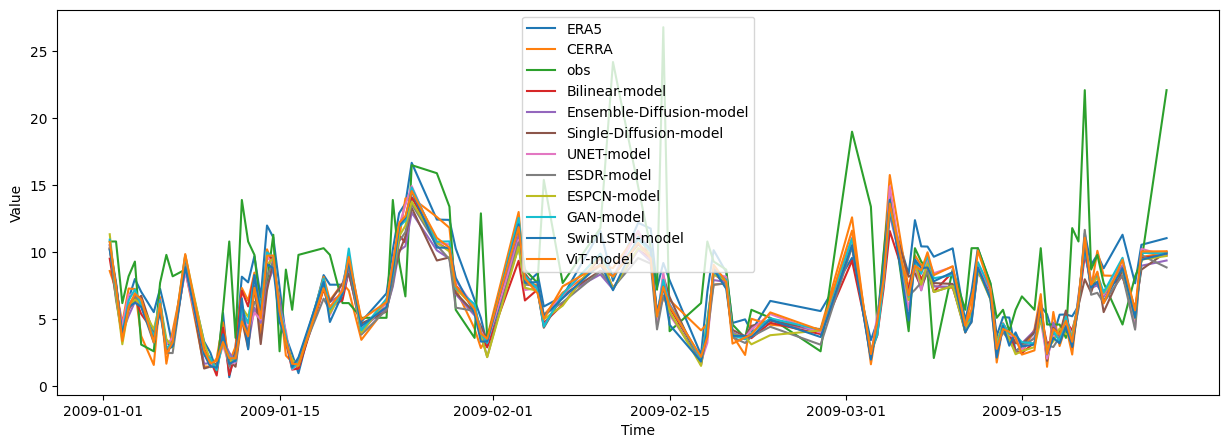

In [37]:
filtered_df = df_complete.query('latitude == 37.9142 and longitude == 12.4914')[:100]

fig, ax = plt.subplots(figsize=(15,5))

# Plot the two columns
ax.plot(filtered_df['actual_time'], filtered_df['ERA5'], label='ERA5')
ax.plot(filtered_df['actual_time'], filtered_df['CERRA'], label='CERRA')
ax.plot(filtered_df['actual_time'], filtered_df['observed_value'], label='obs')
for name in models_names:
    ax.plot(filtered_df['actual_time'], filtered_df[name], label=name)

# Set the labels for the x- and y-axes
ax.set_xlabel('Time')
ax.set_ylabel('Value')

# Add a legend
ax.legend()
plt.savefig("/kaggle/working/error_one_site_obs.jpg")
# Display the plot
plt.show()


In [ ]:
filtered_df.head(20)

In [23]:
compression_opts = dict(method='zip',
                        archive_name='complete_comparison_2009.csv')  
df_complete.to_csv('compete_comparison_2009.zip', index=False,
          compression=compression_opts) 

In [59]:
grouped_df = df_complete.groupby("actual_time").mean()
grouped_df

,latitude,longitude,observed_value,ERA5,CERRA,longitude_CERRA,latitude_CERRA,Bilinear-model,Ensemble-Diffusion-model,Single-Diffusion-model,...,GAN-model,SwinLSTM-model,ViT-model,Ensemble-Diffusion-model-2,GAN-model_Err,SwinLSTM-model_Err,ViT-model_Err,Ensemble-Diffusion-model-2_Err,Ensemble-Diffusion-model-1,Ensemble-Diffusion-model-1_Err
actual_time,,,,,,,,,,,,,,,,,,,,,
2009-01-01 12:00:00+00:00,43.144644,11.821978,4.823333,4.407577,3.844379,11.794444,43.122222,3.897414,4.994828,3.854249,...,4.202552,4.137461,3.906750,4.023859,6.170462,5.876312,8.320726,6.780555,4.108130,6.925246
2009-01-02 00:00:00+00:00,42.970325,12.348162,6.532500,3.286158,2.913011,12.318750,42.950000,3.124703,4.497540,3.509287,...,3.480093,3.537220,3.783613,3.493119,23.560702,24.035938,25.072905,23.442271,3.594944,23.401638
2009-01-02 12:00:00+00:00,43.074733,11.534350,4.388333,3.103564,3.238665,11.500000,43.050000,2.704759,3.620990,2.550134,...,2.771386,2.570873,2.651709,2.484884,5.302364,6.284618,6.420997,7.400640,2.508794,7.467945
2009-01-03 00:00:00+00:00,43.151950,12.117633,5.823333,4.384618,4.954954,12.091667,43.125000,4.136991,5.847579,4.960467,...,5.170402,4.964493,5.118489,4.754098,5.445405,3.579940,4.542917,7.029457,4.794602,7.960023
2009-01-03 12:00:00+00:00,42.183100,11.348486,6.450000,4.861215,4.495975,11.314286,42.157143,4.514879,5.419124,4.379388,...,4.852274,4.320513,4.368642,4.301562,7.117456,9.426699,8.630194,10.881335,4.523230,9.160097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-28 12:00:00+00:00,42.543500,11.537256,2.792222,4.041529,2.671817,11.511111,42.516667,3.649237,4.142690,3.138245,...,3.564099,3.370017,3.389402,3.214564,2.861740,3.218450,3.149919,3.006463,3.156282,2.901123
2009-12-29 00:00:00+00:00,43.234650,10.678420,2.857000,2.747132,3.093659,10.650000,43.210000,2.413771,3.599029,2.763349,...,2.667678,2.708477,2.981112,2.667226,4.261046,4.723306,4.157473,4.617926,2.715964,4.595024
2009-12-29 12:00:00+00:00,43.234367,11.562044,2.625556,3.388227,3.598437,11.533333,43.211111,3.054982,4.199659,3.084132,...,3.135494,3.118166,3.140264,3.134025,4.006934,4.081475,3.825544,4.618810,3.210010,4.427369


In [60]:
def moving_avg(array,window):
    return np.convolve(array, np.ones(window)/window, mode='same')

In [61]:
x = np.arange(0,len(grouped_df),1)

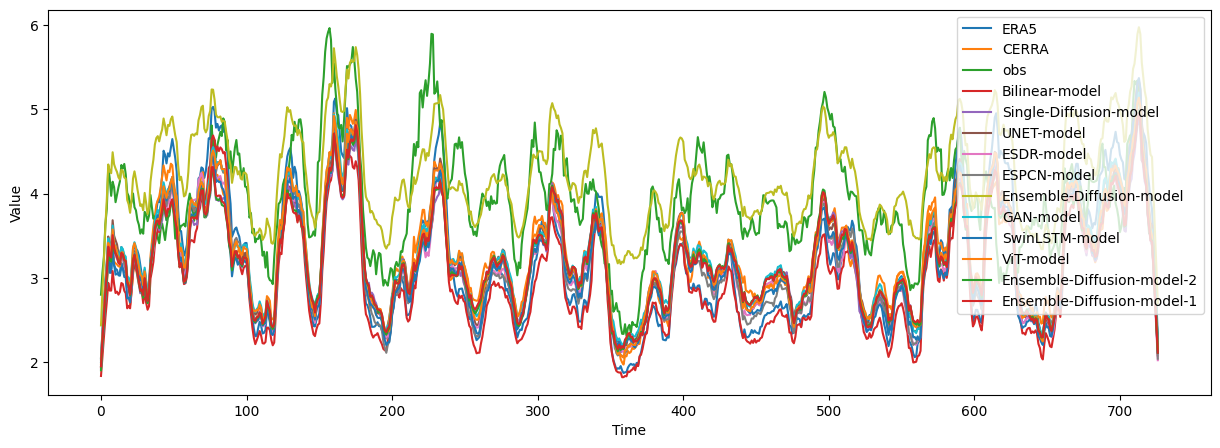

In [62]:
window = 10

fig, ax = plt.subplots(figsize=(15,5))

# Plot the two columns
ax.plot(x, moving_avg(grouped_df['ERA5'],window), label='ERA5')
ax.plot(x, moving_avg(grouped_df['CERRA'],window), label='CERRA')
ax.plot(x, moving_avg(grouped_df['observed_value'],window), label='obs')
for name in models_names:
    ax.plot(x, moving_avg(grouped_df[name],window), label=name)

# Set the labels for the x- and y-axes
ax.set_xlabel('Time')
ax.set_ylabel('Value')

# Add a legend
ax.legend()
plt.savefig("/kaggle/working/error_one_site_obs.jpg")
# Display the plot
plt.show()

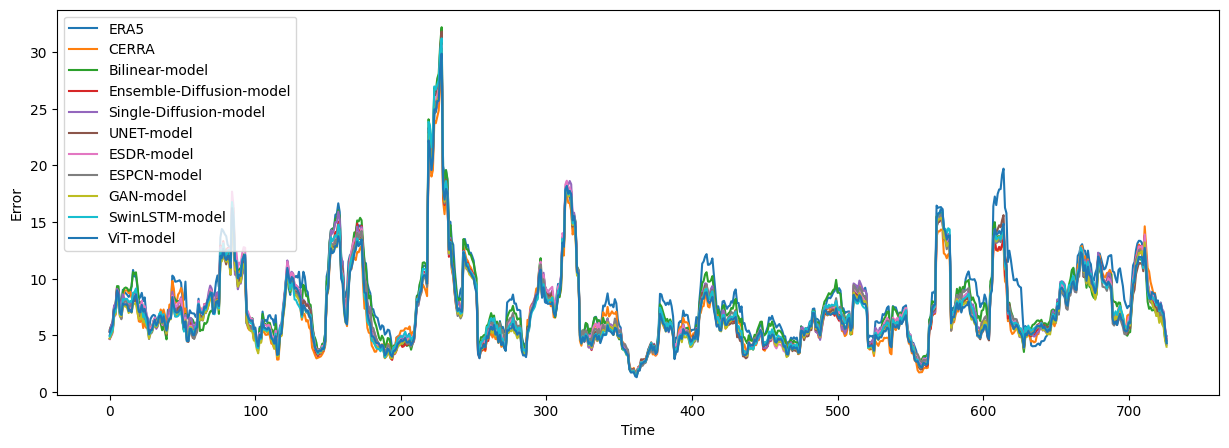

In [44]:
window = 10

x = np.arange(0,len(grouped_df),1)

#colors = [ERA, ]

fig, ax = plt.subplots(figsize=(15,5))

# Plot the two columns
ax.plot(x, moving_avg(grouped_df['ERA5_Err'],window), label='ERA5')
ax.plot(x, moving_avg(grouped_df['CERRA_Err'],window), label='CERRA')
#ax.plot(x, moving_avg(grouped_df['observed_value'],window), label='obs')
for name in models_names:
    ax.plot(x, moving_avg(grouped_df[name+"_Err"],window), label=name)

# Set the labels for the x- and y-axes
ax.set_xlabel('Time')
ax.set_ylabel('Error')

# Add a legend
ax.legend()
plt.savefig("/kaggle/working/error_one_site_obs.jpg")
# Display the plot
plt.show()

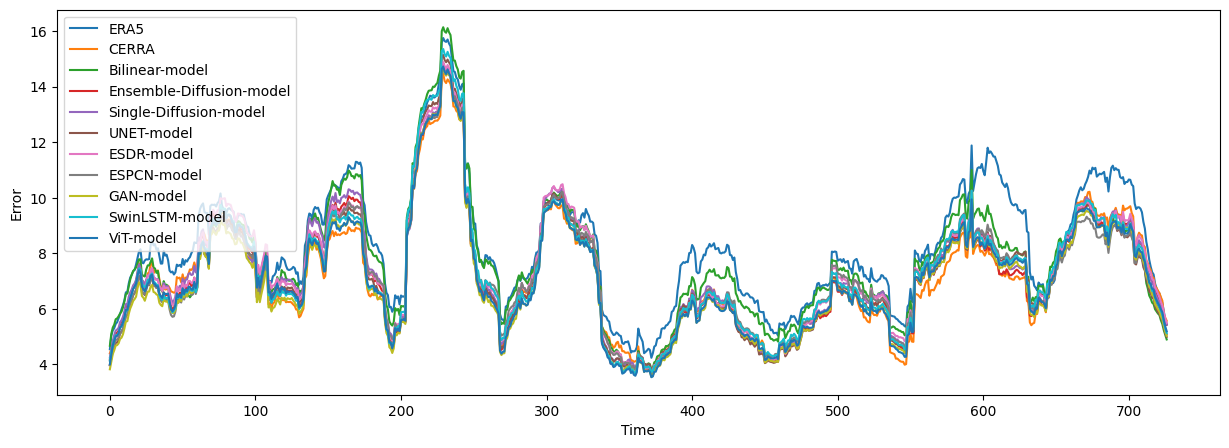

In [45]:
window = 40

fig, ax = plt.subplots(figsize=(15,5))

# Plot the two columns
ax.plot(x, moving_avg(grouped_df['ERA5_Err'],window), label='ERA5')
ax.plot(x, moving_avg(grouped_df['CERRA_Err'],window), label='CERRA')
#ax.plot(x, moving_avg(grouped_df['observed_value'],window), label='obs')
for name in models_names:
    ax.plot(x, moving_avg(grouped_df[name+"_Err"],window), label=name)

# Set the labels for the x- and y-axes
ax.set_xlabel('Time')
ax.set_ylabel('Error')

# Add a legend
ax.legend()
plt.savefig("/kaggle/working/error_one_site_obs.jpg")
# Display the plot
plt.show()